In [48]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from lifelines import WeibullAFTFitter, ExponentialFitter, LogLogisticAFTFitter, LogNormalAFTFitter
import matplotlib.pyplot as plt
from scipy.stats import lognorm


class AFTModelSelector:
    """
    A class for selecting the best AFT (Accelerated Failure Time) model among Weibull, Exponential,
    Log-Normal, and Log-Logistic models based on AIC, and generating churn rate and customer lifetime value (CLV) 
    predictions for a specified number of time periods.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing survival data.
    - primary_col(str): The column name in the DataFrame representing the primary key.
    - duration_col (str): The column name in the DataFrame representing the duration or time-to-event.
    - event_col (str): The column name in the DataFrame representing the event indicator.

    Attributes:
    - data (pd.DataFrame): The input DataFrame containing survival data.
    - primary(str): The column name in the DataFrame representing the primary key.
    - duration_col (str): The column name in the DataFrame representing the duration or time-to-event.
    - event_col (str): The column name in the DataFrame representing the event indicator.
    - aft_model (lifelines.Fitter): The selected AFT model based on AIC.
    - predictions_df (pd.DataFrame): DataFrame containing churn and CLV predictions for a specified number of time periods.
    """
    
    def __init__(self, data: pd.DataFrame , primary_col:str,  duration_col : str, event_col: str):
        self.data = data
        self.primary = primary_col
        self.duration_col = duration_col
        self.event_col = event_col
        self.aft_model = None
        self.predictions_df = None
        self.clv_prediction = None

            
            
    def select_best_model(self):
        """
        Selects the best AFT model among Weibull, Exponential, Log-Normal, and Log-Logistic models based on AIC.
        Stores the selected model in the 'aft_model' attribute.
        """
        models = {
            'Weibull': WeibullAFTFitter(),
            'Exponential': ExponentialFitter(),
            'LogNormal': LogNormalAFTFitter(),
            'LogLogistic': LogLogisticAFTFitter(),
        }

        aic_values = {}
        survival_functions = {}

        # Handle zero values in the duration column
        self.data[self.duration_col] = self.data[self.duration_col].replace(0, 0.0001)

        for model_name, model in models.items():
            if model_name == 'Exponential':
                model.fit(self.data[self.duration_col], self.data[self.event_col])
                models[model_name] = model
            else:
                model.fit(self.data, duration_col=self.duration_col, event_col=self.event_col)
                models[model_name] = model


            aic = model.AIC_
            aic_values[model_name] = aic

            # Store survival functions
            if model_name in ['Weibull', 'LogNormal','LogLogistic']:
                survival_functions[model_name] = model.predict_survival_function(self.data)
            elif model_name == 'Exponential':
                # For LogNormal which has predict_survival_function
                predictions = model.survival_function_
                survival_functions[model_name] = predictions
            else:
                raise AttributeError(f"{model_name} has no attribute 'survival_function_' or 'predict_survival_function'.")

        # Find the model with the minimum AIC
        best_model = min(aic_values, key=aic_values.get)

        # Store AIC values and survival functions in self
        self.aic_values = aic_values
        self.models = models
        self.survival_functions = survival_functions

        # Store the selected model
        self.aft_model = models[best_model]




    def fit_and_predict(self, n_time_periods: int):
        """
        Fits the selected AFT model and generates churn predictions for a specified number of time periods.
        Stores the predictions in the 'predictions_df' attribute.

        Parameters:
        - n_time_periods (int): The number of time periods for which predictions should be generated.
            
        Returns:
        - str: A message indicating the model ran successfully. 
        """
        if self.aft_model is None:
            return

        # Handle zero values in the duration column
        # self.data[self.duration_col] = self.data[self.duration_col].replace(0, 0.0001)

        predictions_df_list = []

        for time_period in range(1, n_time_periods + 1):
            customer_data = pd.DataFrame({
                'customer_id': self.data[self.primary],
                'pred_period': time_period
            })

            # Generate survival predictions 
            predictions = self.aft_model.predict_survival_function(self.data, times=[time_period])

            #obtaining churn predictions
            churn = round(1 - predictions, 5)
            # Convert predictions to a DataFrame
            predictions_df = pd.DataFrame(churn.T.values, columns=['churn_rate'])

            # Concatenate customer_id and time_period with predictions DataFrame
            result_df = pd.concat([customer_data, predictions_df], axis=1)

            # Append to the list
            predictions_df_list.append(result_df)

        # Concatenate all predictions into a single DataFrame
        self.predictions_df = pd.concat(predictions_df_list, ignore_index=True)

    def calculate_clv(self, MM=1300, r=0.1):
        """
        Calculate Customer Lifetime Value (CLV) for each customer in the predictions DataFrame.

        Parameters:
            - MM (float): A constant representing the monetary value.
            - r (float): The periodic interest rate for discounting.

        Returns:
            - pd.Series: Series containing CLV values for each customer.
        """
        if self.predictions_df is None:
            return
        
        #Preparing data for calculating CLV
        self.clv_prediction = self.predictions_df.pivot(index='customer_id', columns='pred_period', values='churn_rate')
        #Calculating again the Survival rates from Churn rates df
        self.clv_prediction = 1 - self.clv_prediction
        data_clv = self.clv_prediction
        #Calculating clv
        sequence = list(range(1, len(data_clv.columns) + 1))

        # Iterating over each column in data_clv
        for num in sequence:
            # Discount the values in the column based on time-value-of-money calculation
            data_clv.iloc[:, num - 1] /= (1 + r/12) ** (num - 1)

        # Calculate CLV for each row
        data_clv['CLV'] = MM * data_clv.sum(axis=1)
        self.clv_prediction['CLV'] = data_clv['CLV']

        

    def plot_survival_functions(self):
        """
        Plot survival functions for all models.
        """
        plt.figure(figsize=(10, 6))
        for model_name, survival_function in self.survival_functions.items():
            plt.plot(survival_function.index, survival_function.mean(1), label=model_name)

        plt.title('Survival Functions for AFT Models')
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.legend()
        plt.show()


***Parametric models:AFT***

In [49]:
df = pd.read_csv('telco.csv')
encode_cols = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat', 'churn']
survival_df = pd.get_dummies(df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=True)
 
survival_df.head()

,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_Yes
0,1,13,44,9,64,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
1,2,11,33,7,136,False,True,False,False,False,...,False,False,True,True,False,True,False,False,True,True
2,3,68,52,24,116,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,4,33,33,12,33,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
4,5,23,30,9,30,True,False,False,True,False,...,False,False,True,False,False,True,False,True,False,False


In [81]:
# Assuming df has columns 'customer_id', 'duration', and 'event'
primary_col = 'ID'
duration_col = 'tenure'
event_col = 'churn_Yes'

# Instantiate the AFTModelSelector
aft_selector = AFTModelSelector(survival_df, primary_col, duration_col, event_col)

# Select the best AFT model
aft_selector.select_best_model()

# Fit the selected model and generate churn predictions for 5 time periods
aft_selector.fit_and_predict(n_time_periods=50)

# Calculate CLV for each customer based on the final model
aft_selector.calculate_clv()

In [82]:
#Comparing models using summaries
for model_name, model in aft_selector.models.items():
    model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1457.96
         time fit was run = 2023-11-26 21:00:01 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                               
lambda_ CLV                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        ID                               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        address                           0.05       1.05       0.01             0.02             0.08                 1.02                 1.08
        age                               0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
        custcat_E-service                 1.20       3.32       0.37             0.47             1.93                 1.59                 6.91
        custcat_Plus service              0.93       2.54       0.36             0.22             1.64                 1.25                 5.17
        custcat_Total service             1.22       3.40       0.46             0.32             2.12                 1.38                 8.34
        ed_Did not complete high school   0.54       1.71       0.22             0.10             0.98                 1.10                 2.65
        ed_High school degree             0.36       1.43       0.17             0.02             0.70                 1.02                 2.01
        ed_Post-undergraduate degree      0.16       1.17       0.19            -0.22             0.54                 0.80                 1.71
        ed_Some college                   0.32       1.37       0.18            -0.03             0.66                 0.97                 1.94
        forward_Yes                      -0.14       0.87       0.17            -0.47             0.19                 0.62                 1.21
        gender_Male                      -0.01       0.99       0.10            -0.21             0.20                 0.81                 1.22
        income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        internet_Yes                     -0.95       0.39       0.29            -1.51            -0.39                 0.22                 0.68
        marital_Unmarried                -0.44       0.64       0.18            -0.79            -0.10                 0.45                 0.91
        region_Zone 2                    -0.08       0.92       0.13            -0.33             0.17                 0.72                 1.19
        region_Zone 3                     0.14       1.16       0.13            -0.11             0.40                 0.90                 1.48
        retire_Yes                        0.11       1.11       0.53            -0.92             1.14                 0.40                 3.12
        voice_Yes                        -0.38       0.68       0.20            -0.78             0.02                 0.46                 1.02
        Intercept                         3.38      29.25       0.62             2.16             4.59                 8.65                98.94
rho_    Intercept                         0.18       1.20       0.05             0.08             0.28                 1.08                 1.33

                                          cmp to     z      p   -log2(p)
param   covariate                                                       
lambda_ CLV                           

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 1000 total observations, 726 right-censored observations>
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1606.98
               hypothesis = lambda_ != 0

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 129.66       7.83           114.30           145.01

          cmp to     z      p   -log2(p)
lambda_     0.00 16.55 <0.005     202.03
---
AIC = 3215.96

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1454.15
         time fit was run = 2023-11-26 21:00:01 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    CLV                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       ID                               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       address                           0.04       1.04       0.01             0.02             0.07                 1.02                 1.07
       age                               0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
       custcat_E-service                 1.06       2.88       0.36             0.35             1.76                 1.42                 5.81
       custcat_Plus service              0.93       2.54       0.35             0.24             1.62                 1.28                 5.05
       custcat_Total service             1.20       3.33       0.44             0.35             2.06                 1.42                 7.81
       ed_Did not complete high school   0.37       1.45       0.22            -0.06             0.81                 0.94                 2.25
       ed_High school degree             0.30       1.36       0.18            -0.05             0.66                 0.95                 1.94
       ed_Post-undergraduate degree     -0.05       0.95       0.22            -0.49             0.38                 0.61                 1.47
       ed_Some college                   0.28       1.33       0.19            -0.08             0.65                 0.92                 1.91
       forward_Yes                      -0.20       0.82       0.19            -0.57             0.17                 0.56                 1.19
       gender_Male                       0.04       1.04       0.11            -0.19             0.26                 0.83                 1.30
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.78       0.46       0.27            -1.32            -0.25                 0.27                 0.78
       marital_Unmarried                -0.44       0.64       0.17            -0.78            -0.10                 0.46                 0.90
       region_Zone 2                    -0.09       0.91       0.14            -0.38             0.19                 0.69                 1.21
       region_Zone 3                     0.06       1.06       0.14            -0.22             0.34                 0.80                 1.40
       retire_Yes                        0.02       1.03       0.45            -0.85             0.90                 0.43                 2.47
       voice_Yes                        -0.41       0.67       0.21            -0.81            -0.00                 0.44                 1.00
       Intercept                         2.56      12.91       0.63             1.32             3.80                 3.73                44.65
sigma_ Intercept                         0.27       1.31       0.05             0.18             0.36                 1.20                 1.43

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    CLV                                 0.00  0.02   0.98  

<lifelines.LogLogisticAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1455.13
         time fit was run = 2023-11-26 21:00:02 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
alpha_ CLV                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       ID                               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       address                           0.04       1.04       0.01             0.01             0.07                 1.01                 1.07
       age                               0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
       custcat_E-service                 1.04       2.84       0.37             0.32             1.77                 1.37                 5.87
       custcat_Plus service              0.87       2.38       0.36             0.16             1.57                 1.18                 4.82
       custcat_Total service             1.20       3.31       0.45             0.32             2.08                 1.37                 8.01
       ed_Did not complete high school   0.45       1.57       0.22             0.01             0.89                 1.01                 2.44
       ed_High school degree             0.32       1.38       0.18            -0.02             0.67                 0.98                 1.96
       ed_Post-undergraduate degree     -0.06       0.94       0.21            -0.48             0.36                 0.62                 1.43
       ed_Some college                   0.26       1.29       0.18            -0.10             0.61                 0.91                 1.84
       forward_Yes                      -0.19       0.82       0.18            -0.55             0.17                 0.58                 1.18
       gender_Male                       0.02       1.02       0.11            -0.19             0.24                 0.82                 1.27
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.81       0.44       0.28            -1.36            -0.26                 0.26                 0.77
       marital_Unmarried                -0.43       0.65       0.18            -0.78            -0.09                 0.46                 0.92
       region_Zone 2                    -0.05       0.95       0.14            -0.31             0.22                 0.73                 1.25
       region_Zone 3                     0.12       1.13       0.14            -0.14             0.39                 0.87                 1.48
       retire_Yes                        0.07       1.08       0.48            -0.87             1.02                 0.42                 2.77
       voice_Yes                        -0.36       0.70       0.21            -0.77             0.05                 0.46                 1.05
       Intercept                         2.54      12.74       0.64             1.30             3.79                 3.66                44.38
beta_  Intercept                         0.35       1.41       0.05             0.24             0.45                 1.28                 1.56

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
alpha_ CLV                                 0.00  0.01   1.00

In [83]:
#Comparing models using aic-s: we can see the model will choose LogNormal since it has the lowest AIC.
aft_selector.aic_values

{'Weibull': 2959.926745081074,
 'Exponential': 3215.9608134637247,
 'LogNormal': 2952.299616462576,
 'LogLogistic': 2954.2568053434306}

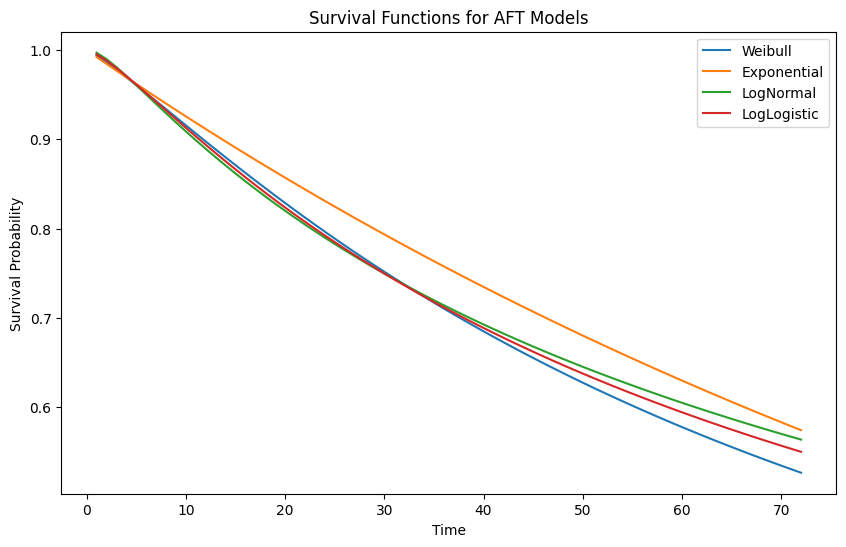

In [84]:
#Visualizing the model plots
aft_selector.plot_survival_functions()

In [85]:
#Choosing the best model
model_name =aft_selector.aft_model.__class__.__name__
print(f"The best model with the lowest AIC is {model_name}.")

The best model with the lowest AIC is LogNormalAFTFitter.


Choosing the LogNormalAFTFitter method is recommended because it specifically addresses survival data patterns, leveraging the log-normal distribution. Its selection based on the lowest AIC indicates a good balance between model fit and simplicity, making it a straightforward and effective choice for analyzing survival data.

In [86]:
# Keeping only the significant features
coefficients = aft_selector.aft_model.summary['coef']
p_values = aft_selector.aft_model.summary['p']
significance_level = 0.05

# Identify significant features and extract column names without prefixes
significant_feature_names = [feature[1] for feature, p_value in zip(coefficients.index, p_values) if p_value < significance_level and feature[1] != 'Intercept']

# Keep only significant features in the original DataFrame
significant_data = survival_df[significant_feature_names]


In [87]:
#Keeping the final model
final_model = aft_selector.aft_model

***CLV***

In [92]:
#Calculating CLV-s for each customer
aft_selector.calculate_clv()
aft_selector.clv_prediction.head()

pred_period,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,CLV
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.99940,0.988403,0.975494,0.961180,0.945894,0.929960,0.913617,0.897055,0.880406,0.863766,...,0.462577,0.454040,0.445690,0.437522,0.429535,0.421719,0.414077,0.406592,0.399270,42980.400804
2,0.99987,0.990863,0.981169,0.970856,0.960027,0.948783,0.937222,0.925419,0.913447,0.901360,...,0.561602,0.553270,0.545072,0.537007,0.529072,0.521259,0.513579,0.506018,0.498580,47596.427349
3,1.00000,0.991736,0.983530,0.975391,0.967321,0.959298,0.951341,0.943431,0.935588,0.927791,...,0.705330,0.699190,0.693104,0.687056,0.681061,0.675112,0.669214,0.663355,0.657546,53225.842626
4,0.99885,0.985904,0.970203,0.952684,0.934063,0.914793,0.895226,0.875570,0.856001,0.836639,...,0.410617,0.402248,0.394095,0.386139,0.378377,0.370805,0.363421,0.356215,0.349182,40320.421318
5,0.99994,0.991289,0.982261,0.972855,0.963122,0.953100,0.942845,0.932411,0.921832,0.911142,...,0.598107,0.590059,0.582124,0.574294,0.566567,0.558956,0.551445,0.544041,0.536742,49155.991861


In [93]:
survival_df['CLV'] = aft_selector.clv_prediction['CLV'].values
df['CLV'] = aft_selector.clv_prediction['CLV'].values
survival_df

,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_Yes,CLV
0,1,13,44,9,64,True,False,False,False,False,...,False,True,False,False,True,False,False,False,True,42980.400804
1,2,11,33,7,136,False,True,False,False,False,...,False,True,True,False,True,False,False,True,True,47596.427349
2,3,68,52,24,116,False,True,False,True,False,...,False,False,False,False,False,False,True,False,False,53225.842626
3,4,33,33,12,33,True,False,True,False,True,...,False,False,False,False,False,False,False,False,True,40320.421318
4,5,23,30,9,30,True,False,False,True,False,...,False,True,False,False,True,False,True,False,False,49155.991861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,10,39,0,27,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,32057.168023
996,997,7,34,2,22,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,25437.862184
997,998,67,59,40,944,False,True,True,False,False,...,False,False,True,True,True,False,False,True,False,52955.220923
998,999,70,49,18,87,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,48068.955798


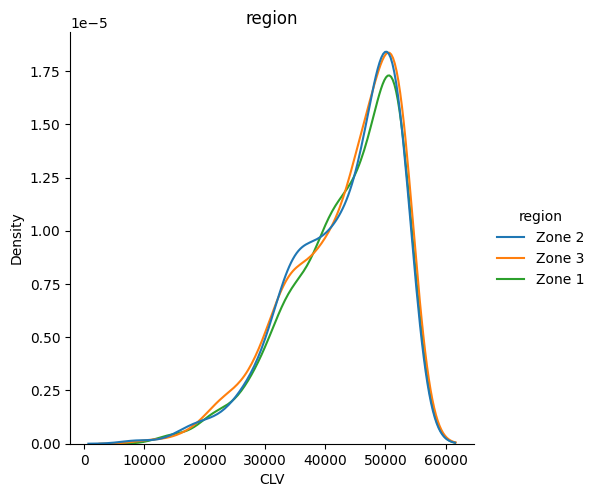

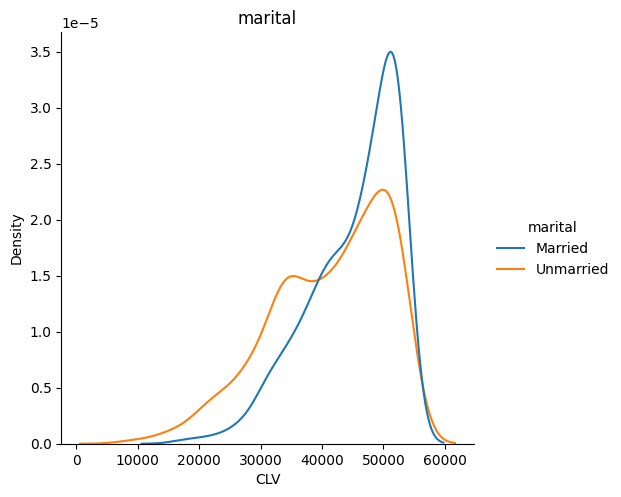

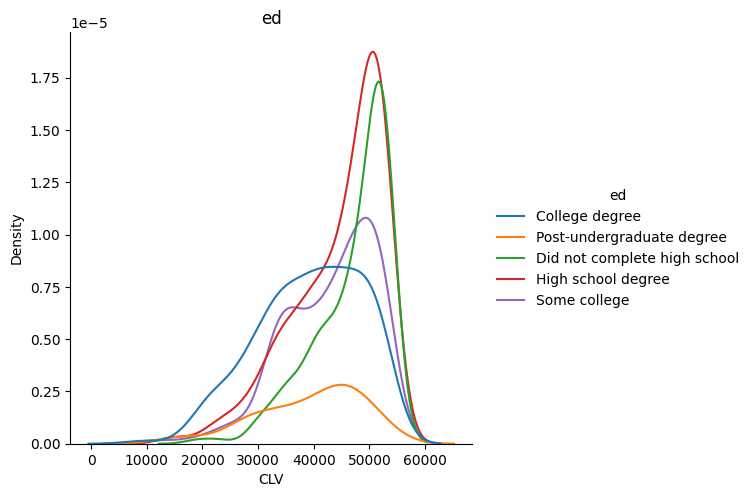

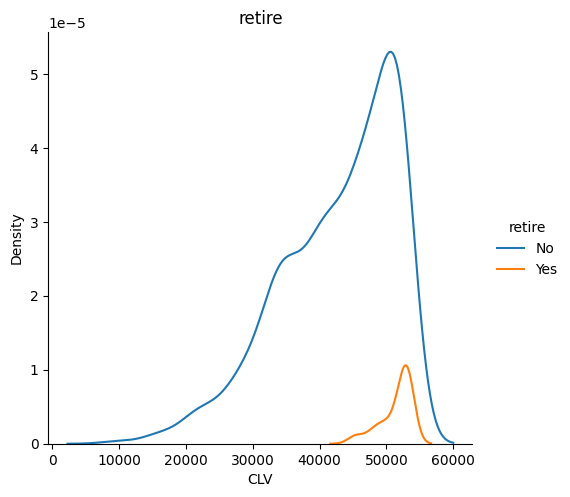

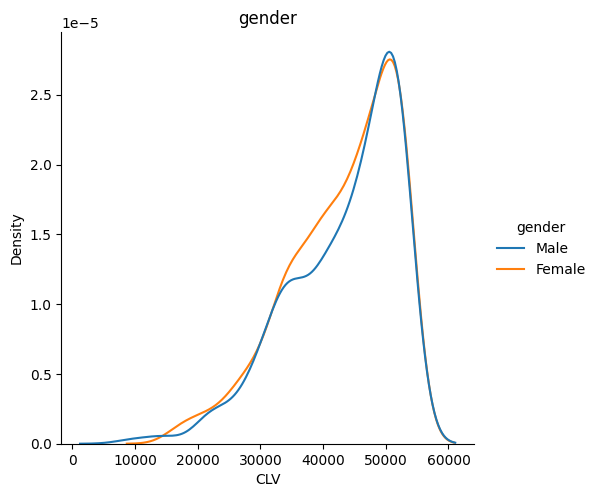

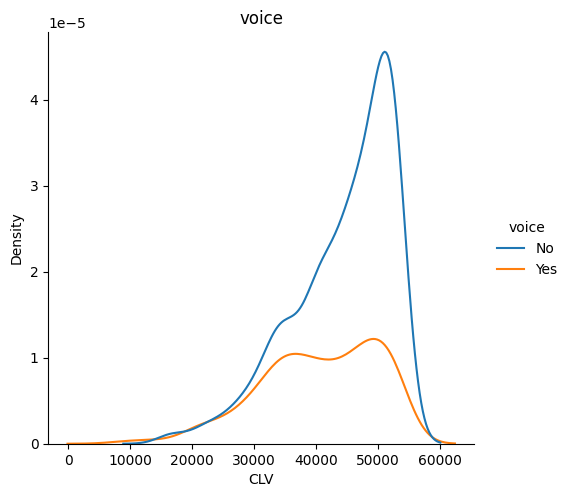

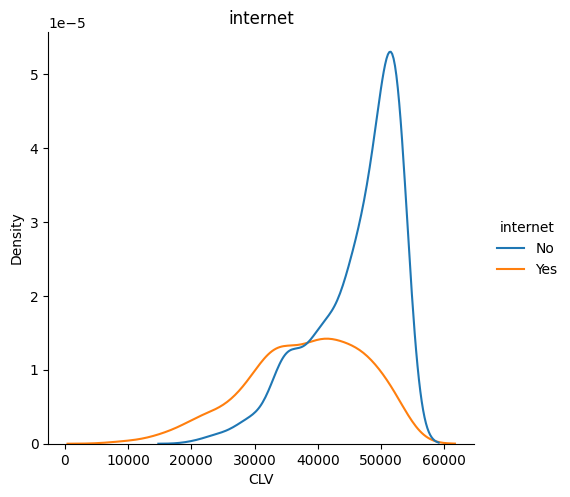

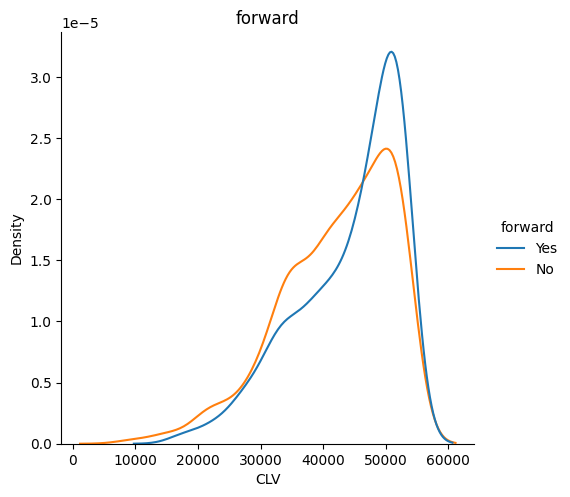

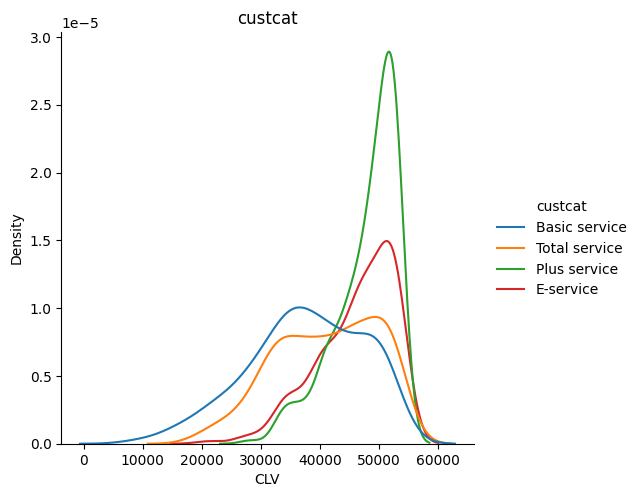

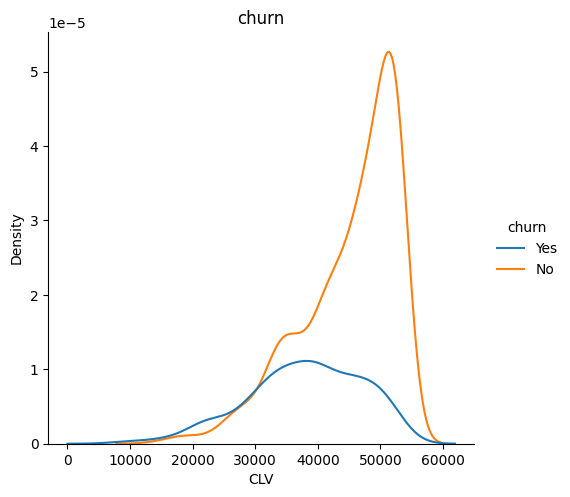

In [94]:
import seaborn as sns
categorical = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat', 'churn']
for column in categorical:
    sns.displot(df, kind='kde', x='CLV', hue=column)
    plt.title(column)

In [95]:
for column in categorical:
    print(df.groupby(column)[["CLV"]].mean(), "\n")

                 CLV
region              
Zone 1  43265.132622
Zone 2  43018.460101
Zone 3  43160.738244 

                    CLV
marital                
Married    45165.825551
Unmarried  41167.819181 

                                       CLV
ed                                        
College degree                39307.755293
Did not complete high school  46997.524776
High school degree            44514.429225
Post-undergraduate degree     39297.328777
Some college                  43024.199303 

                 CLV
retire              
No      42735.656281
Yes     51484.082947 

                 CLV
gender              
Female  42998.497555
Male    43305.608898 

                CLV
voice              
No     44315.605080
Yes    40470.957888 

                   CLV
internet              
No        46126.515558
Yes       38029.550275 

                  CLV
forward              
No       42149.816041
Yes      44172.161463 

                        CLV
custcat                   


**Report: Understanding Churn Risk and Improving Retention**

Interpretation of Coefficients:
To make sense of the numbers in the chosen Log-Normal AFT model, we're looking at Customer Lifetime Value (CLV) across different customer groups. The place where people live(region) doesn't make much of a difference, but being married(marital status) seems to make customers more likely to stay. Education doesn't seem to impact things much, and if someone isn't retired(retirement status), they're more likely have highes customer lifetime valus. Suprisingly, gender doesn't play a big role either. Also, if a customer's plan doesn't include voice or internet services, they're more likely to bring more revenue.

Identification of Most Valuable Segments:
Identifying the most valuable customer segments involves considering higher CLV, longer customer relationships, and a lower likelihood of leaving. This analysis highlights specific segments, such as those subscribed to 'E-service,' 'Plus service,' and 'Total service,' along with customers using internet and voice services. This strategic focus aligns with the overarching goal of retaining customers who have the potential for long-term value creation.

Estimation of Annual Retention Budget:
To keep the customers satisfied, setting aside some funds is crucial.Selecting a practical budget allocation of 10%, estimating the number of customers at risk within a year reveals an approximate count of 500. Then, we calculate how much money we should allocate to make sure we retain as many as possible. This budgeting approach ensures we're investing wisely in customer satisfaction.

Additional Suggestions for Retention:
Beyond budget considerations, there are other things to be done. Offering attractive deals and personalized messages for the married customers, tailoring services for the non-retired group to fit their busy lives, and ensuring that customers without voice or internet services feel valued. Incorporating regular surveys allows us to gather feedback and continuously improve the strategies for customer retention.
